In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.autograd import Variable

import numpy as np
import cvxpy as cp

from free_flyer.free_flyer import FreeFlyer
from free_flyer.utils import *
import pickle, os

In [2]:
#load train/test data
config_fn = './free_flyer/config/default_hydra.p'
prob = FreeFlyer(config_fn) #use default config, pass different config file oth.

config_file = open(config_fn,'rb')
dataset_name, _, _ = pickle.load(config_file); config_file.close()

relative_path = os.getcwd()
dataset_fn = relative_path + '/free_flyer/data/' + dataset_name

train_file = open(dataset_fn+'/spaced_apart/train.p','rb')
# p_train, x_train, u_train, y_train, c_train, times_train = pickle.load(train_file)
train_data = pickle.load(train_file)
train_file.close()
x_train = train_data[1]
y_train = train_data[3]

test_file = open(dataset_fn+'/spaced_apart/test.p','rb')
# p_test, x_test, u_test, y_test, c_test, times_test = pickle.load(test_file)
test_data = pickle.load(test_file)
p_test, x_test, u_test, y_test, c_test, times_test = test_data
test_file.close()

n_test = x_test.shape[0]

In [3]:
prob = FreeFlyer(config_fn) #use default config, pass different config file oth.

In [4]:
from solvers.coco_ff import CoCo_FF

system = 'free_flyer'
prob_features = ['x0', 'obstacles_map']

max_evals = 1
coco_obj = CoCo_FF(system, prob, prob_features)

n_features = 4
coco_obj.construct_strategies(n_features, train_data)
print(coco_obj.n_strategies)

458


In [6]:
coco_obj.problem.R = 1000.*np.eye(coco_obj.problem.m)
coco_obj.problem.init_mlopt_problem()

In [7]:
coco_obj.setup_network(neurons=128)
coco_obj.model_fn

'/home/acauligi/CoCo/CoCoFF_free_flyer_20211005_1449.pt'

In [8]:
fn_saved = 'models/CoCoFF_free_flyer_20210125_0808.pt'
coco_obj.load_network(fn_saved)

Loading presaved classifier model from models/CoCoFF_free_flyer_20210125_0808.pt


In [9]:
coco_obj.model

CNNet(
  (conv_activation): ReLU()
  (ff_activation): ReLU()
  (conv_layers): ModuleList(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): Conv2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
    (2): Conv2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
  )
  (ff_layers): ModuleList(
    (0): Linear(in_features=260, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=458, bias=True)
  )
)

In [ ]:
# coco_obj.training_params['TRAINING_ITERATIONS'] = 1000
# coco_obj.training_params['BATCH_SIZE'] = 128
# coco_obj.training_params['TEST_BATCH_SIZE'] = 2000

# coco_obj.train(train_data, summary_writer_fn="runs/sim_spaced_apart_128", verbose=False)

In [19]:
# neuron_256_fn = '/home/acauligi/CoCo/CoCoFF_free_flyer_20210927_1513.pt'

In [10]:
prob_params = {}
idx = np.random.randint(test_data[1].shape[0])
for k in p_test.keys():
    prob_params[k] = p_test[k][idx]

prob_success, cost, total_time, n_evals, optvals = coco_obj.forward(prob_params, solver=cp.GUROBI, max_evals=10)

if prob_success:
    print(n_evals)
else:
    print('Failed')

1


In [8]:
n_succ = 0
count = 0
gurobi_mlopt_fail = 0

costs_coco = []
total_time_coco = []
num_solves_coco = []

cost_ratios_coco = []
costs_ip = []
total_time_ip = []
num_solves_ip = []

import time
t0 = time.time()
for ii in range(n_test):
    if ii % 2000 == 0:
        print('{} / {}'.format(ii,n_test))
        file = open('sim_N6.txt','w')
        file.write("Done with {}/{} in {}s".format(ii, n_test, time.time()-t0))
        file.close()
    prob_params = {}
    for k in p_test.keys():
        prob_params[k] = p_test[k][ii]

    try:
        prob_success, cost, total_time, n_evals, optvals = coco_obj.forward(prob_params, max_evals=max_evals, solver=cp.GUROBI)

        if prob_success:
            n_succ += 1
            costs_coco += [cost]
            total_time_coco += [total_time]
            num_solves_coco += [n_evals]

            true_cost = c_test[ii]
            costs_ip += [true_cost]
            total_time_ip += [times_test[ii]]

            cost_ratios_coco += [cost / true_cost]
        count += 1
    except (KeyboardInterrupt, SystemExit):
        raise
    except:
#         print('Solver failed at {}'.format(ii))
        gurobi_mlopt_fail += 1
        continue

costs_coco = np.array(costs_coco)
cost_ratios_coco = np.array(cost_ratios_coco)
total_time_coco = np.array(total_time_coco)
num_solves_coco = np.array(num_solves_coco, dtype=int)

costs_ip = np.array(costs_ip)
total_time_ip = np.array(total_time_ip)
num_solves_ip = np.array(num_solves_ip, dtype=int)

coco_percentage = 100 * float(n_succ) / float(count)

0 / 10000
Academic license - for non-commercial use only - expires 2022-07-05
Using license file /home/acauligi/licenses/gurobi.lic


/home/acauligi/CoCo/coco/lib/python3.6/site-packages/cvxpy/problems/problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2000 / 10000
4000 / 10000
6000 / 10000
8000 / 10000


# Receding horizon planning
Select one of the below cells for a particular parameter set

In [10]:
rand_idx = 1930
obstacles = p_test['obstacles'][rand_idx]
x0, xg = p_test['x0'][rand_idx], p_test['xg'][rand_idx]
x0 = np.array([1.0, 1.0, 0.0, 0.0])

In [538]:
rand_idx = 6656
obstacles = p_test['obstacles'][rand_idx]
x0, xg = p_test['x0'][rand_idx], p_test['xg'][rand_idx]
x0 = np.array([1., 0.2, 0.0, 0.0])

In [390]:
rand_idx = 9398
obstacles = p_test['obstacles'][rand_idx]
x0, xg = p_test['x0'][rand_idx], p_test['xg'][rand_idx]
x0 = np.array([0.65, 1., 0.0, 0.0])

In [445]:
rand_idx = 1558
obstacles = p_test['obstacles'][rand_idx]
x0, xg = p_test['x0'][rand_idx], p_test['xg'][rand_idx]
x0 = np.array([1.7, 0.7, -0.15, 0.])

In [ ]:
rand_idx = 1558
obstacles = p_test['obstacles'][rand_idx]
x0, xg = p_test['x0'][rand_idx], p_test['xg'][rand_idx]
x0 = np.array([2.5, 0.2, -0.15, 0.05])

In [479]:
rand_idx = 1450
obstacles = p_test['obstacles'][rand_idx]
x0, xg = p_test['x0'][rand_idx], p_test['xg'][rand_idx]
x0 = np.array([0.5, 0.2, -0., 0.0])

In [533]:
rand_idx = 6793
obstacles = p_test['obstacles'][rand_idx]
x0, xg = p_test['x0'][rand_idx], p_test['xg'][rand_idx]
x0 = np.array([0.5, 0.2, -0.1, -0.03])

In [531]:
rand_idx = np.random.randint(n_test)
print(rand_idx)
obstacles = p_test['obstacles'][rand_idx]
x0, xg = p_test['x0'][rand_idx], p_test['xg'][rand_idx]
x0 = np.array([0.5, 0.2, -0.1, -0.03])

1764


### Plot of initial condition and obstacle set

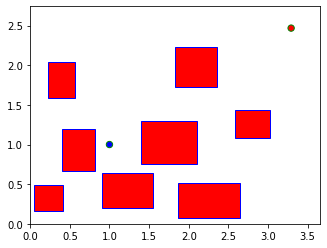

In [11]:
plt.axes()
for ii_obs in range(prob.n_obs):
    obstacle = obstacles[:, ii_obs]
    rectangle = plt.Rectangle((obstacle[0], obstacle[2]), \
                              obstacle[1]-obstacle[0], obstacle[3]-obstacle[2], \
                             fc='red', ec='blue')
    plt.gca().add_patch(rectangle)
    plt.axis('scaled')

circle = plt.Circle((x0[0],x0[1]), 0.04, fc='blue',ec="green")
plt.gca().add_patch(circle)
circle = plt.Circle((xg[0],xg[1]), 0.04, fc='red',ec="green")
plt.gca().add_patch(circle)
ax = plt.gca()
ax.margins(0)
ax.set(xlim=(prob.posmin[0],prob.posmax[0]), ylim=(prob.posmin[1],prob.posmax[1]))
plt.show()

# Run MPC

In [12]:
mpc_steps = 151
Xs, Us = [x0], []
opt_control = []
n_fails = 0

ii_step, run_mpc = 0, True
goal_thresh = 0.1
while ii_step < mpc_steps and run_mpc:
    p_dict = {}
    p_dict['x0'] = x0
    p_dict['obstacles'] = obstacles
    p_dict['xg'] = xg

    try:
        prob_success, cost, total_time, n_evals, optvals = coco_obj.forward(p_dict, max_evals=max_evals, solver=cp.GUROBI)
    except:
        prob_success, cost, total_time, n_evals, optvals = coco_obj.forward(p_dict, max_evals=max_evals, solver=cp.SCS)
    if not prob_success and len(opt_control) == 0:
        print('Controller failed at time {}'.format(ii_step))
        break
    elif prob_success:
        opt_control = []
        # Unpack primal solutions
        x_star, u_star, y_star = optvals
        for i_t in range(coco_obj.problem.N-1):
            opt_control.append(u_star[:, i_t])
    if not prob_success:
        n_fails += 1

    u0 = opt_control[0]
    Us.append(u0)
    opt_control = opt_control[1:]

    # Update initial state
    x0 = prob.Ak @ x0 + prob.Bk @ u0
    Xs.append(x0)

    ii_step += 1

    if np.sum(np.abs(x0 - xg)) <= goal_thresh:
        run_mpc = False
x_opt = np.stack(Xs).T
u_opt = np.stack(Us).T

n_fails

Academic license - for non-commercial use only - expires 2022-07-05
Using license file /home/acauligi/licenses/gurobi.lic


/home/acauligi/CoCo/coco/lib/python3.6/site-packages/cvxpy/problems/problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


3

### Interpolate trajectory smoothly between waypoints of returned solution using double integrator dynamics

In [13]:
dh = coco_obj.problem.Ak[0,2]
x0 = x_opt[:, 0]

Tf = (coco_obj.problem.N-1)*dh
Tf = (x_opt.shape[1]-1)*dh
Ts = np.cumsum(dh*np.ones(x_opt.shape[1])) - dh

n_sample = 10000
x_traj = np.zeros((2*coco_obj.problem.n, 0))
x_next = np.copy(x0)

for tt in np.linspace(0.0, Tf, n_sample):
    if tt >= Ts[-1]:
        continue
    x_traj = np.hstack((x_traj, np.expand_dims(x_next, axis=1)))

    t_idx = np.where(tt >= Ts)[0][-1]
    x_prev, u_prev = x_opt[:, t_idx], u_opt[:, t_idx]
    x_next[:2] = x_prev[:2] + x_prev[2:]*(tt - Ts[t_idx]) + 0.5*u_prev*(tt - Ts[t_idx])**2
    x_next[2:] = x_prev[2:] + u_prev*(tt - Ts[t_idx])

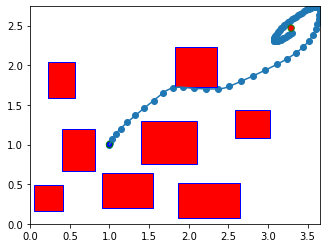

In [14]:
plt.axes()
for ii_obs in range(prob.n_obs):
    obstacle = obstacles[:, ii_obs]
    rectangle = plt.Rectangle((obstacle[0], obstacle[2]), \
                              obstacle[1]-obstacle[0], obstacle[3]-obstacle[2], \
                             fc='red', ec='blue')
    plt.gca().add_patch(rectangle)
    plt.axis('scaled')

circle = plt.Circle((x0[0],x0[1]), 0.04, fc='blue',ec="green")
plt.gca().add_patch(circle)
circle = plt.Circle((xg[0],xg[1]), 0.04, fc='red',ec="green")
plt.gca().add_patch(circle)

plt.plot(x_traj[0,:], x_traj[1,:])
plt.scatter(x_opt[0,:], x_opt[1,:])

ax = plt.gca()
ax.margins(0)
ax.set(xlim=(prob.posmin[0],prob.posmax[0]), ylim=(prob.posmin[1],prob.posmax[1]))
plt.show()